# March Madness Prediction

## Overview

###

### Goal
Submissions are based on the Brier Score, the goal will be to minimize the brier score between the predicted probabilities and the actual game outcomes. The Brier score measures the accuracy of probablistic predition, in this case the mean square error. 

The brier score can be thought of as a cost function that measures the average squared difference between the predicted probabilities and the actual outcomes.

$$
Brier = \frac{1}{N} \sum_{i=1}^{N} (p_i - o_i)^2
$$

where $p_i$ is the predicted probability of the event and $o_i$ is the actual outcome. The Brier score can span across all items in a set of N predictions.

Therefore, minimizing the Brier score will result in a more accurate prediction.


In [55]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sp
import xgboost as xgb
import sklearn as sk
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, mean_absolute_error, brier_score_loss

# Style
plt.style.use("dark_background")
px.defaults.template = 'plotly_dark'

## Load Data

Set up a data dictionary that will store the data for each file, this will make it easier to access data from the csvs. Not all files are used in the prediction process, but they are included for completeness.

Additionaly I am going to create a Sample Submission Dataframe that will be used to store the predictions for the sample submission, this will be populated with the predictions from the model later on.


In [ ]:
# Load Data
import os

# Load Data - Use forward slashes or os.path.join for cross-platform compatibility
path = './data/*.csv'
try:
    csv_files = glob.glob(path)
    if not csv_files:
        # Try alternative path for Windows
        path = '../data\\*.csv'
        csv_files = glob.glob(path)
    
    data = {}
    for p in csv_files:
        # Extract filename without extension
        filename = p.split('/')[-1].split('\\')[-1].split('.')[0]  # Handle both separators
        data[filename] = pd.read_csv(p, encoding='latin-1')
    
except Exception as e:
    print(f"Error loading files: {e}")

# Create Teams Dataframe
teams = pd.concat([data['MTeams'], data['WTeams']])
teams_spelling = pd.concat([data['MTeamSpellings'], data['WTeamSpellings']])
teams_spelling = teams_spelling.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()
teams_spelling.columns = ['TeamID', 'TeamNameCount']
teams = pd.merge(teams, teams_spelling, how='left', on=['TeamID'])

# Create Season Dataframes and S/T Flag
season_compact_results = pd.concat([data['MRegularSeasonCompactResults'], data['WRegularSeasonCompactResults']]).assign(ST='S')
season_detailed_results = pd.concat([data['MRegularSeasonDetailedResults'], data['WRegularSeasonDetailedResults']]).assign(ST='S')
tourney_compact_results = pd.concat([data['MNCAATourneyCompactResults'], data['WNCAATourneyCompactResults']]).assign(ST='T')
tourney_detailed_results = pd.concat([data['MNCAATourneyDetailedResults'], data['WNCAATourneyDetailedResults']]).assign(ST='T')

# Create Tourney Dataframes
lots = pd.concat([data['MNCAATourneySlots'], data['WNCAATourneySlots']])
seeds = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']])
seeds['SeedValue'] = seeds['Seed'].str.extract(r'(\d+)').astype(int)
seeds_dict = {'_'.join(map(str,[int(k1),k2])):int(v[1:3]) for k1, v, k2 in seeds[['Season', 'Seed', 'TeamID']].values}
game_cities = pd.concat([data['MGameCities'], data['WGameCities']])
seasons = pd.concat([data['MSeasons'], data['WSeasons']])
cities = data['Cities']

# Create Sample Submission Dataframe
sub = data['SampleSubmissionStage1']
del data

# Seeds Dictionary
seeds = {'_'.join(map(str,[int(k1),k2])):int(v[1:3]) for k1, v, k2 in seeds[['Season', 'Seed', 'TeamID']].values}

Here we concatinate the regular season and tournament detailed results into a single dataframe. We also add additional features to the dataframe that will be used in the model.

This includes derived features such as the score difference, home advantage, and shooting percentages. We also add the derived features to the detailed results dataframe.

In [57]:
# Create Detailed Results Dataframe
all_detailed_results = pd.concat([season_detailed_results, tourney_detailed_results])
all_detailed_results.reset_index(drop=True, inplace=True)
all_detailed_results['WLoc'] = all_detailed_results['WLoc'].map({'A': 1, 'H': 2, 'N': 3})

# Add additional features to detailed results
all_detailed_results['ID'] = all_detailed_results.apply(lambda r: '_'.join(map(str, [r['Season']]+sorted([r['WTeamID'],r['LTeamID']]))), axis=1)
all_detailed_results['IDTeams'] = all_detailed_results.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'],r['LTeamID']]))), axis=1)
all_detailed_results['Team1'] = all_detailed_results.apply(lambda r: sorted([r['WTeamID'],r['LTeamID']])[0], axis=1)
all_detailed_results['Team2'] = all_detailed_results.apply(lambda r: sorted([r['WTeamID'],r['LTeamID']])[1], axis=1)
all_detailed_results['IDTeam1'] = all_detailed_results.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
all_detailed_results['IDTeam2'] = all_detailed_results.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)

all_detailed_results['Team1Seed'] = all_detailed_results['IDTeam1'].map(seeds).fillna(0)
all_detailed_results['Team2Seed'] = all_detailed_results['IDTeam2'].map(seeds).fillna(0)

all_detailed_results['ScoreDiff'] = all_detailed_results['WScore'] - all_detailed_results['LScore']
all_detailed_results['Pred'] = all_detailed_results.apply(lambda r: 1. if sorted([r['WTeamID'],r['LTeamID']])[0]==r['WTeamID'] else 0., axis=1)
all_detailed_results['ScoreDiffNorm'] = all_detailed_results.apply(lambda r: r['ScoreDiff'] * -1 if r['Pred'] == 0. else r['ScoreDiff'], axis=1)
all_detailed_results['SeedDiff'] = all_detailed_results['Team1Seed'] - all_detailed_results['Team2Seed'] 
all_detailed_results = all_detailed_results.fillna(-1)

# Add derived features to detaifled results
all_detailed_results['ScoreDiff'] = all_detailed_results['WScore'] - all_detailed_results['LScore']
all_detailed_results['HomeAdvantage'] = (all_detailed_results['WLoc'] == 2).astype(int)

# Calculate shooting percentages (handling division by zero)
all_detailed_results['WFGPct'] = np.where(all_detailed_results['WFGA'] > 0, 
                                        all_detailed_results['WFGM'] / all_detailed_results['WFGA'], 0)
all_detailed_results['WFG3Pct'] = np.where(all_detailed_results['WFGA3'] > 0, 
                                        all_detailed_results['WFGM3'] / all_detailed_results['WFGA3'], 0)
all_detailed_results['WFTPct'] = np.where(all_detailed_results['WFTA'] > 0, 
                                        all_detailed_results['WFTM'] / all_detailed_results['WFTA'], 0)
all_detailed_results['LFGPct'] = np.where(all_detailed_results['LFGA'] > 0, 
                                        all_detailed_results['LFGM'] / all_detailed_results['LFGA'], 0)
all_detailed_results['LFG3Pct'] = np.where(all_detailed_results['LFGA3'] > 0, 
                                        all_detailed_results['LFGM3'] / all_detailed_results['LFGA3'], 0)
all_detailed_results['LFTPct'] = np.where(all_detailed_results['LFTA'] > 0, 
                                        all_detailed_results['LFTM'] / all_detailed_results['LFTA'], 0)

# Add statistical differences
all_detailed_results['ReboundDiff'] = (all_detailed_results['WOR'] + all_detailed_results['WDR']) - \
                                    (all_detailed_results['LOR'] + all_detailed_results['LDR'])
all_detailed_results['AssistDiff'] = all_detailed_results['WAst'] - all_detailed_results['LAst']
all_detailed_results['TurnoverDiff'] = all_detailed_results['WTO'] - all_detailed_results['LTO']
all_detailed_results['StealDiff'] = all_detailed_results['WStl'] - all_detailed_results['LStl']
all_detailed_results['BlockDiff'] = all_detailed_results['WBlk'] - all_detailed_results['LBlk']
all_detailed_results['FoulDiff'] = all_detailed_results['WPF'] - all_detailed_results['LPF']

# Data Exploration

In [58]:
# Basic dataset information
print("="*60)
print("DATASET OVERVIEW")
print("="*60)

# Calculate team counts from the teams dataframe (which combines M and W)
# We can estimate individual counts based on TeamID ranges or check the original data
m_teams_count = len([t for t in teams['TeamID'] if t < 3000])  # Men's teams typically have lower IDs
w_teams_count = len([t for t in teams['TeamID'] if t >= 3000])  # Women's teams typically have higher IDs

print(f"\n📊 Teams Information:")
print(f"   Total teams (M+W): {len(teams):,}")
print(f"   Men's teams (estimated): {m_teams_count:,}")
print(f"   Women's teams (estimated): {w_teams_count:,}")

print(f"\n📅 Seasons Coverage:")
print(f"   Regular season games: {len(season_compact_results):,}")
print(f"   Tournament games: {len(tourney_compact_results):,}")
print(f"   Season range: {season_compact_results['Season'].min()} - {season_compact_results['Season'].max()}")

print(f"\n🏀 Game Types:")
print(f"   Regular season detailed: {len(season_detailed_results):,}")
print(f"   Tournament detailed: {len(tourney_detailed_results):,}")
print(f"   Total detailed games: {len(all_detailed_results):,}")

print(f"\n🎯 Submission Information:")
print(f"   Predictions needed: {len(sub):,}")
print(f"   Sample submission columns: {list(sub.columns)}")

# Display sample of key dataframes
print(f"\n📋 Sample Team Data:")
display(teams.head())

print(f"\n📋 Sample Submission Data:")
display(sub.head())


DATASET OVERVIEW

📊 Teams Information:
   Total teams (M+W): 758
   Men's teams (estimated): 380
   Women's teams (estimated): 378

📅 Seasons Coverage:
   Regular season games: 329,958
   Tournament games: 4,168
   Season range: 1985 - 2025

🏀 Game Types:
   Regular season detailed: 200,590
   Tournament detailed: 2,276
   Total detailed games: 202,866

🎯 Submission Information:
   Predictions needed: 507,108
   Sample submission columns: ['ID', 'Pred']

📋 Sample Team Data:


,TeamID,TeamName,FirstD1Season,LastD1Season,TeamNameCount
0,1101,Abilene Chr,2014.0,2025.0,3
1,1102,Air Force,1985.0,2025.0,2
2,1103,Akron,1985.0,2025.0,1
3,1104,Alabama,1985.0,2025.0,1
4,1105,Alabama A&M,2000.0,2025.0,2



📋 Sample Submission Data:


,ID,Pred
0,2021_1101_1102,0.5
1,2021_1101_1103,0.5
2,2021_1101_1104,0.5
3,2021_1101_1105,0.5
4,2021_1101_1106,0.5


### Team Performance Analysis

Let's analyze team performance patterns and identify strong vs weak teams based on their historical performance.


In [59]:
# Team win/loss analysis
print("="*60)
print("TEAM PERFORMANCE ANALYSIS")
print("="*60)

# Calculate team statistics
team_stats = []

# For winning teams
win_stats = all_detailed_results.groupby('WTeamID').agg({
    'WScore': ['count', 'mean'],
    'LScore': 'mean',
    'Season': ['min', 'max', 'nunique']
}).round(2)
win_stats.columns = ['Games_Won', 'Avg_Score_When_Winning', 'Avg_Opp_Score_When_Winning', 'First_Season', 'Last_Season', 'Seasons_Played']
win_stats = win_stats.reset_index()
win_stats['TeamID'] = win_stats['WTeamID']

# For losing teams  
loss_stats = all_detailed_results.groupby('LTeamID').agg({
    'LScore': ['count', 'mean'],
    'WScore': 'mean',
}).round(2)
loss_stats.columns = ['Games_Lost', 'Avg_Score_When_Losing', 'Avg_Opp_Score_When_Losing']
loss_stats = loss_stats.reset_index()
loss_stats['TeamID'] = loss_stats['LTeamID']

# Merge team statistics
team_performance = pd.merge(teams[['TeamID', 'TeamName']], win_stats[['TeamID', 'Games_Won', 'Avg_Score_When_Winning', 'Seasons_Played']], on='TeamID', how='left')
team_performance = pd.merge(team_performance, loss_stats[['TeamID', 'Games_Lost', 'Avg_Score_When_Losing']], on='TeamID', how='left')

# Fill missing values and calculate derived metrics
team_performance = team_performance.fillna(0)
team_performance['Total_Games'] = team_performance['Games_Won'] + team_performance['Games_Lost']
team_performance['Win_Percentage'] = (team_performance['Games_Won'] / team_performance['Total_Games'] * 100).round(2)
team_performance['Win_Percentage'] = team_performance['Win_Percentage'].fillna(0)

# Display top and bottom performing teams
print("🏆 TOP 10 TEAMS BY WIN PERCENTAGE (min 50 games):")
top_teams = team_performance[team_performance['Total_Games'] >= 50].nlargest(10, 'Win_Percentage')
display(top_teams[['TeamName', 'Win_Percentage', 'Total_Games', 'Games_Won', 'Avg_Score_When_Winning', 'Seasons_Played']])

print("\n📉 BOTTOM 10 TEAMS BY WIN PERCENTAGE (min 50 games):")
bottom_teams = team_performance[team_performance['Total_Games'] >= 50].nsmallest(10, 'Win_Percentage')
display(bottom_teams[['TeamName', 'Win_Percentage', 'Total_Games', 'Games_Won', 'Avg_Score_When_Winning', 'Seasons_Played']])

# Win percentage distribution
print(f"\n📊 WIN PERCENTAGE DISTRIBUTION:")
print(f"   Mean win percentage: {team_performance['Win_Percentage'].mean():.1f}%")
print(f"   Median win percentage: {team_performance['Win_Percentage'].median():.1f}%")
print(f"   Standard deviation: {team_performance['Win_Percentage'].std():.1f}%")
print(f"   Teams with >70% win rate: {len(team_performance[team_performance['Win_Percentage'] > 70])}")
print(f"   Teams with <30% win rate: {len(team_performance[team_performance['Win_Percentage'] < 30])}")


TEAM PERFORMANCE ANALYSIS
🏆 TOP 10 TEAMS BY WIN PERCENTAGE (min 50 games):


,TeamName,Win_Percentage,Total_Games,Games_Won,Avg_Score_When_Winning,Seasons_Played
441,Connecticut,92.70,589.0,546.0,82.83,16.0
403,Baylor,87.15,568.0,495.0,81.71,16.0
473,FGCU,85.29,503.0,429.0,75.05,16.0
668,Stanford,83.77,567.0,475.0,76.40,16.0
654,South Carolina,83.58,548.0,458.0,76.02,16.0
601,Notre Dame,83.54,559.0,467.0,82.16,16.0
110,Gonzaga,83.25,782.0,651.0,83.25,23.0
489,Gonzaga,81.25,528.0,429.0,75.92,16.0
730,WI Green Bay,81.20,500.0,406.0,70.75,16.0
546,Maryland,80.08,532.0,426.0,82.65,16.0



📉 BOTTOM 10 TEAMS BY WIN PERCENTAGE (min 50 games):


,TeamName,Win_Percentage,Total_Games,Games_Won,Avg_Score_When_Winning,Seasons_Played
426,Centenary,5.56,54.0,3.0,70.00,2.0
431,Chicago St,14.45,436.0,63.0,70.89,13.0
453,Delaware St,19.29,425.0,82.0,67.54,15.0
51,Chicago St,21.12,644.0,136.0,75.91,22.0
667,St Peter's,21.21,481.0,102.0,64.98,15.0
751,Queens NC,21.52,79.0,17.0,69.29,3.0
568,MS Valley St,22.00,450.0,99.0,68.35,16.0
469,Evansville,23.09,472.0,109.0,70.61,16.0
170,MD E Shore,23.28,640.0,149.0,71.91,22.0
394,Ark Pine Bluff,23.39,436.0,102.0,70.47,16.0



📊 WIN PERCENTAGE DISTRIBUTION:
   Mean win percentage: 47.5%
   Median win percentage: 47.8%
   Standard deviation: 14.8%
   Teams with >70% win rate: 34
   Teams with <30% win rate: 60


### Scoring and Game Patterns

Let's examine scoring patterns, game dynamics, and statistical trends that could be predictive of game outcomes.


SCORING AND GAME PATTERNS
🏀 OVERALL SCORING STATISTICS:
   Average winning score: 74.2
   Average losing score: 61.2
   Average point difference: 13.0
   Median point difference: 11.0
   Std dev of point difference: 10.1

📊 REGULAR SEASON vs TOURNAMENT:
   Regular season avg point diff: 13.0
   Tournament avg point diff: 13.7
   Regular season avg total points: 135.4
   Tournament avg total points: 137.8

🔥 CLOSE GAMES ANALYSIS:
   Games decided by ≤5 points: 51,060 (25.2%)
   Games decided by ≤3 points: 29,724 (14.7%)
   Blowouts (≥20 points): 41,974 (20.7%)

🏠 HOME ADVANTAGE ANALYSIS:
   Home team wins: 115,271 (56.8%)
   Away team wins: 66,096 (32.6%)
   Neutral site games: 21,499 (10.6%)
   Home team avg point margin: 14.5
   Away team avg point margin: 10.7


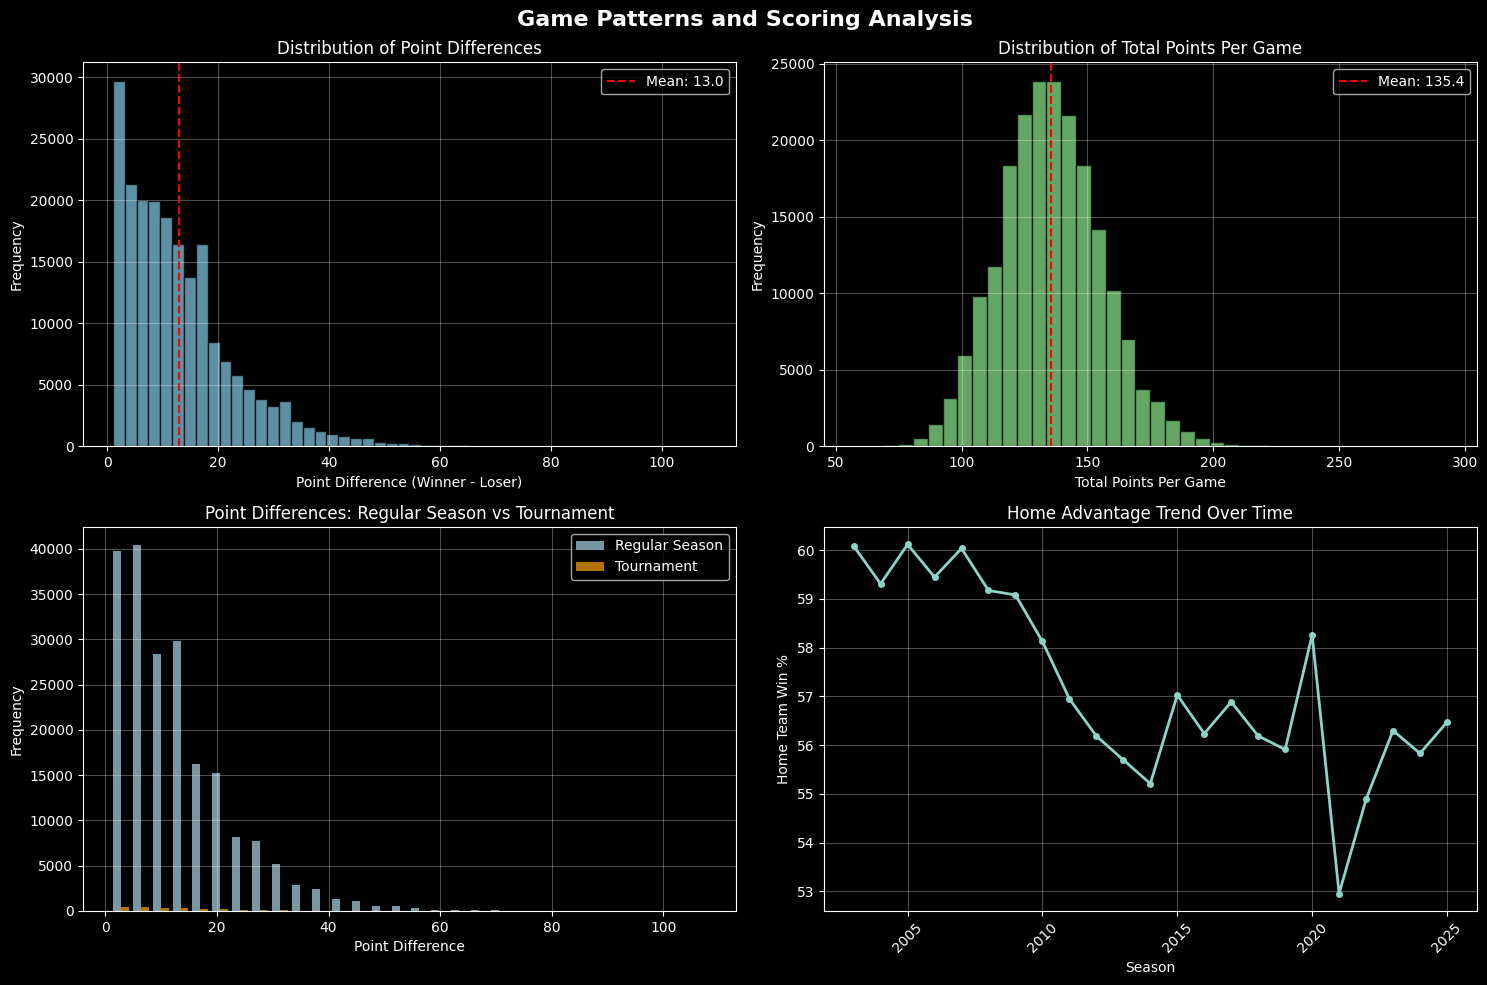

In [60]:
# Scoring analysis
print("="*60)
print("SCORING AND GAME PATTERNS")
print("="*60)

# Overall scoring statistics
print("🏀 OVERALL SCORING STATISTICS:")
print(f"   Average winning score: {all_detailed_results['WScore'].mean():.1f}")
print(f"   Average losing score: {all_detailed_results['LScore'].mean():.1f}")
print(f"   Average point difference: {all_detailed_results['ScoreDiff'].mean():.1f}")
print(f"   Median point difference: {all_detailed_results['ScoreDiff'].median():.1f}")
print(f"   Std dev of point difference: {all_detailed_results['ScoreDiff'].std():.1f}")

# Score distribution by game type
season_games = all_detailed_results[all_detailed_results['ST'] == 'S']
tourney_games = all_detailed_results[all_detailed_results['ST'] == 'T']

print(f"\n📊 REGULAR SEASON vs TOURNAMENT:")
print(f"   Regular season avg point diff: {season_games['ScoreDiff'].mean():.1f}")
print(f"   Tournament avg point diff: {tourney_games['ScoreDiff'].mean():.1f}")
print(f"   Regular season avg total points: {(season_games['WScore'] + season_games['LScore']).mean():.1f}")
print(f"   Tournament avg total points: {(tourney_games['WScore'] + tourney_games['LScore']).mean():.1f}")

# Close games analysis
print(f"\n🔥 CLOSE GAMES ANALYSIS:")
close_games = all_detailed_results[all_detailed_results['ScoreDiff'] <= 5]
very_close_games = all_detailed_results[all_detailed_results['ScoreDiff'] <= 3]
blowouts = all_detailed_results[all_detailed_results['ScoreDiff'] >= 20]

print(f"   Games decided by ≤5 points: {len(close_games):,} ({len(close_games)/len(all_detailed_results)*100:.1f}%)")
print(f"   Games decided by ≤3 points: {len(very_close_games):,} ({len(very_close_games)/len(all_detailed_results)*100:.1f}%)")
print(f"   Blowouts (≥20 points): {len(blowouts):,} ({len(blowouts)/len(all_detailed_results)*100:.1f}%)")

# Home advantage analysis
print(f"\n🏠 HOME ADVANTAGE ANALYSIS:")
home_games = all_detailed_results[all_detailed_results['WLoc'] == 2]  # Home wins
away_games = all_detailed_results[all_detailed_results['WLoc'] == 1]  # Away wins
neutral_games = all_detailed_results[all_detailed_results['WLoc'] == 3]  # Neutral site

total_games = len(all_detailed_results)
print(f"   Home team wins: {len(home_games):,} ({len(home_games)/total_games*100:.1f}%)")
print(f"   Away team wins: {len(away_games):,} ({len(away_games)/total_games*100:.1f}%)")
print(f"   Neutral site games: {len(neutral_games):,} ({len(neutral_games)/total_games*100:.1f}%)")

if len(home_games) > 0:
    print(f"   Home team avg point margin: {home_games['ScoreDiff'].mean():.1f}")
if len(away_games) > 0:
    print(f"   Away team avg point margin: {away_games['ScoreDiff'].mean():.1f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Game Patterns and Scoring Analysis', fontsize=16, fontweight='bold')

# Score difference distribution
axes[0,0].hist(all_detailed_results['ScoreDiff'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(all_detailed_results['ScoreDiff'].mean(), color='red', linestyle='--', label=f'Mean: {all_detailed_results["ScoreDiff"].mean():.1f}')
axes[0,0].set_xlabel('Point Difference (Winner - Loser)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Point Differences')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Total points per game
total_points = all_detailed_results['WScore'] + all_detailed_results['LScore']
axes[0,1].hist(total_points, bins=40, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].axvline(total_points.mean(), color='red', linestyle='--', label=f'Mean: {total_points.mean():.1f}')
axes[0,1].set_xlabel('Total Points Per Game')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Total Points Per Game')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Regular season vs tournament scoring
season_diff = season_games['ScoreDiff']
tourney_diff = tourney_games['ScoreDiff']
axes[1,0].hist([season_diff, tourney_diff], bins=30, alpha=0.7, 
               label=['Regular Season', 'Tournament'], color=['lightblue', 'orange'])
axes[1,0].set_xlabel('Point Difference')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Point Differences: Regular Season vs Tournament')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Home advantage by season
home_adv_by_season = []
seasons_list = sorted(all_detailed_results['Season'].unique())
for season in seasons_list:
    season_data = all_detailed_results[all_detailed_results['Season'] == season]
    home_wins = len(season_data[season_data['WLoc'] == 2])
    total_season_games = len(season_data)
    if total_season_games > 0:
        home_adv_by_season.append(home_wins / total_season_games * 100)
    else:
        home_adv_by_season.append(0)

axes[1,1].plot(seasons_list, home_adv_by_season, marker='o', linewidth=2, markersize=4)
axes[1,1].set_xlabel('Season')
axes[1,1].set_ylabel('Home Team Win %')
axes[1,1].set_title('Home Advantage Trend Over Time')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Tournament Seed Analysis

Let's analyze how tournament seeds perform and look for patterns in upsets and seed-based predictions.


TOURNAMENT SEED ANALYSIS
📈 TOURNAMENT GAMES WITH SEED DATA: 2,276

🌱 SEED DISTRIBUTION:
   Seed  1: 606 appearances
   Seed  2: 476 appearances
   Seed  3: 415 appearances
   Seed  4: 367 appearances
   Seed  5: 309 appearances
   Seed  6: 263 appearances
   Seed  7: 271 appearances
   Seed  8: 233 appearances
   Seed  9: 220 appearances
   Seed 10: 212 appearances
   Seed 11: 281 appearances
   Seed 12: 208 appearances
   Seed 13: 165 appearances
   Seed 14: 152 appearances
   Seed 15: 152 appearances
   Seed 16: 222 appearances

😱 UPSET ANALYSIS:
   Total upsets: 567 out of 2,276 games (24.9%)

📊 UPSET RATE BY SEED DIFFERENCE:
   1 seed difference: 55.0% upset rate (382 games)
   2 seed difference: 70.0% upset rate (50 games)
   3 seed difference: 65.8% upset rate (307 games)
   4 seed difference: 75.4% upset rate (114 games)
   5 seed difference: 63.7% upset rate (237 games)
   6 seed difference: 57.1% upset rate (14 games)
   7 seed difference: 74.6% upset rate (228 games)
   8 see

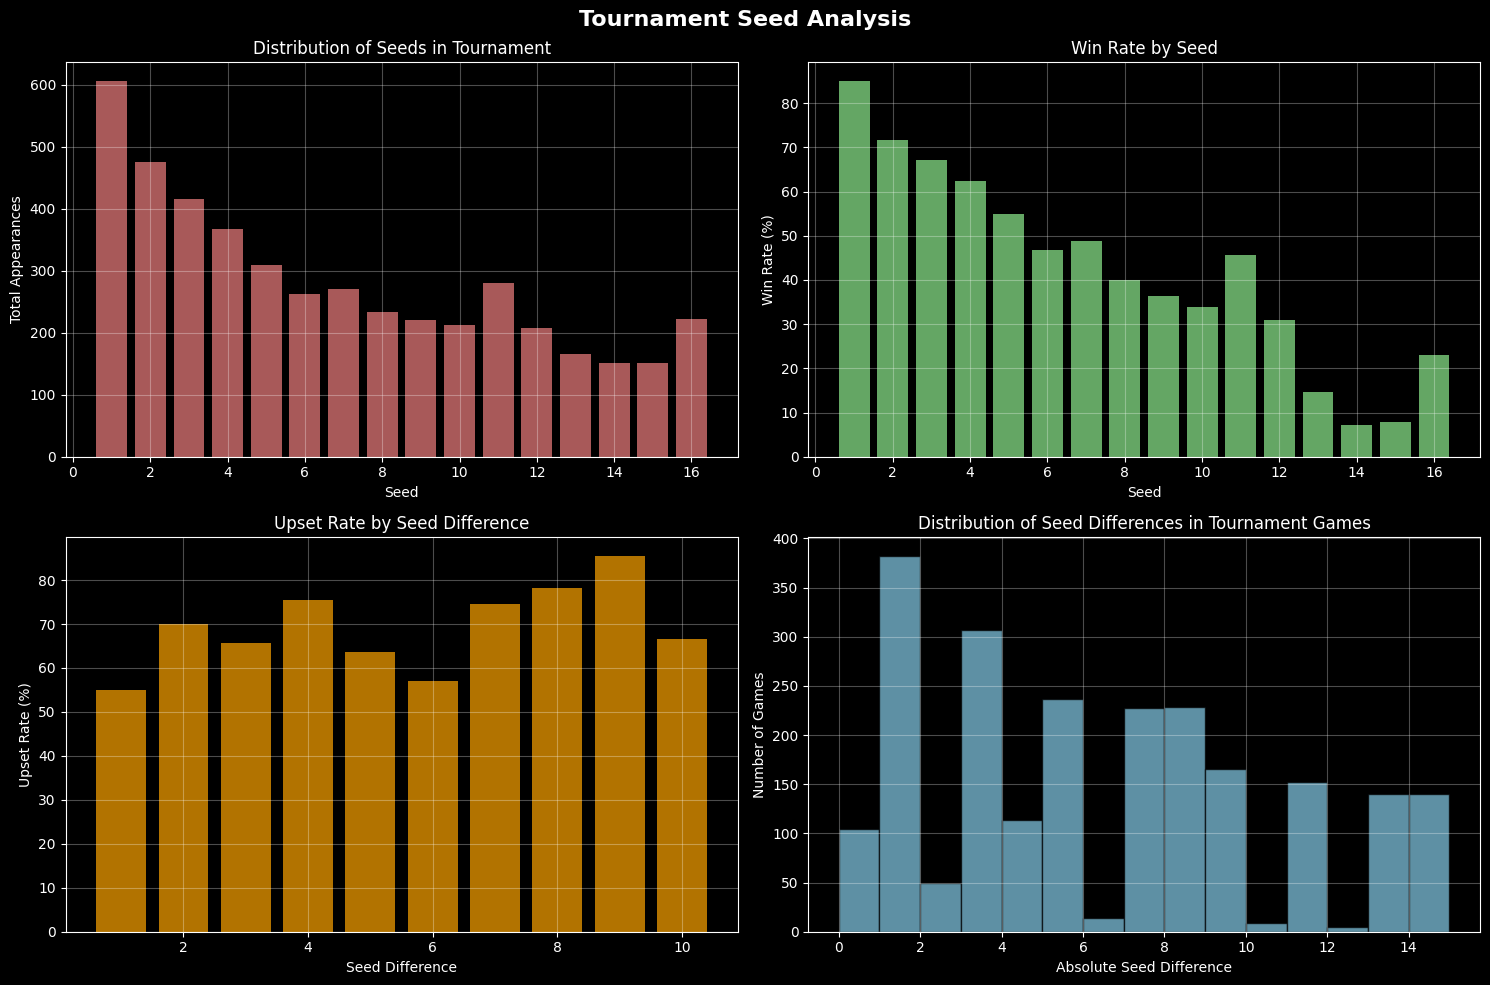

In [61]:
# Tournament seed analysis
print("="*60)
print("TOURNAMENT SEED ANALYSIS")
print("="*60)

# Filter tournament games with seed information
tourney_with_seeds = all_detailed_results[
    (all_detailed_results['ST'] == 'T') & 
    (all_detailed_results['Team1Seed'] > 0) & 
    (all_detailed_results['Team2Seed'] > 0)
]

print(f"📈 TOURNAMENT GAMES WITH SEED DATA: {len(tourney_with_seeds):,}")

if len(tourney_with_seeds) > 0:
    # Seed distribution
    all_seeds = pd.concat([
        tourney_with_seeds[['Team1Seed']].rename(columns={'Team1Seed': 'Seed'}),
        tourney_with_seeds[['Team2Seed']].rename(columns={'Team2Seed': 'Seed'})
    ])
    
    print(f"\n🌱 SEED DISTRIBUTION:")
    seed_counts = all_seeds['Seed'].value_counts().sort_index()
    for seed in range(1, 17):
        if seed in seed_counts.index:
            print(f"   Seed {seed:2d}: {seed_counts[seed]:,} appearances")
    
    # Upset analysis (lower seed beats higher seed)
    upsets = tourney_with_seeds[
        ((tourney_with_seeds['Team1Seed'] > tourney_with_seeds['Team2Seed']) & (tourney_with_seeds['Pred'] == 1)) |
        ((tourney_with_seeds['Team2Seed'] > tourney_with_seeds['Team1Seed']) & (tourney_with_seeds['Pred'] == 0))
    ]
    
    print(f"\n😱 UPSET ANALYSIS:")
    print(f"   Total upsets: {len(upsets):,} out of {len(tourney_with_seeds):,} games ({len(upsets)/len(tourney_with_seeds)*100:.1f}%)")
    
    # Calculate upset probability by seed difference
    upset_by_diff = {}
    for diff in range(1, 16):
        games_with_diff = tourney_with_seeds[abs(tourney_with_seeds['SeedDiff']) == diff]
        if len(games_with_diff) > 0:
            upsets_with_diff = games_with_diff[
                ((games_with_diff['SeedDiff'] > 0) & (games_with_diff['Pred'] == 0)) |
                ((games_with_diff['SeedDiff'] < 0) & (games_with_diff['Pred'] == 1))
            ]
            upset_rate = len(upsets_with_diff) / len(games_with_diff) * 100
            upset_by_diff[diff] = (upset_rate, len(games_with_diff))
    
    print(f"\n📊 UPSET RATE BY SEED DIFFERENCE:")
    for diff in sorted(upset_by_diff.keys())[:10]:  # Show top 10
        rate, count = upset_by_diff[diff]
        print(f"   {diff} seed difference: {rate:.1f}% upset rate ({count} games)")
    
    # Performance by seed
    seed_performance = {}
    for seed in range(1, 17):
        seed_games = tourney_with_seeds[
            (tourney_with_seeds['Team1Seed'] == seed) | 
            (tourney_with_seeds['Team2Seed'] == seed)
        ]
        
        if len(seed_games) > 0:
            # Count wins for this seed
            wins = len(seed_games[
                ((seed_games['Team1Seed'] == seed) & (seed_games['Pred'] == 1)) |
                ((seed_games['Team2Seed'] == seed) & (seed_games['Pred'] == 0))
            ])
            
            win_rate = wins / len(seed_games) * 100
            seed_performance[seed] = (win_rate, wins, len(seed_games))
    
    print(f"\n🏆 WIN RATE BY SEED:")
    for seed in range(1, 17):
        if seed in seed_performance:
            rate, wins, total = seed_performance[seed]
            print(f"   Seed {seed:2d}: {rate:5.1f}% win rate ({wins:3d}/{total:3d} games)")

# Create seed analysis visualizations
if len(tourney_with_seeds) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Tournament Seed Analysis', fontsize=16, fontweight='bold')
    
    # Seed distribution
    seed_dist = all_seeds['Seed'].value_counts().sort_index()
    axes[0,0].bar(seed_dist.index, seed_dist.values, color='lightcoral', alpha=0.7)
    axes[0,0].set_xlabel('Seed')
    axes[0,0].set_ylabel('Total Appearances')
    axes[0,0].set_title('Distribution of Seeds in Tournament')
    axes[0,0].grid(True, alpha=0.3)
    
    # Win rate by seed
    if seed_performance:
        seeds_list = list(seed_performance.keys())
        win_rates = [seed_performance[s][0] for s in seeds_list]
        axes[0,1].bar(seeds_list, win_rates, color='lightgreen', alpha=0.7)
        axes[0,1].set_xlabel('Seed')
        axes[0,1].set_ylabel('Win Rate (%)')
        axes[0,1].set_title('Win Rate by Seed')
        axes[0,1].grid(True, alpha=0.3)
    
    # Upset rate by seed difference
    if upset_by_diff:
        diffs = list(upset_by_diff.keys())[:10]
        upset_rates = [upset_by_diff[d][0] for d in diffs]
        axes[1,0].bar(diffs, upset_rates, color='orange', alpha=0.7)
        axes[1,0].set_xlabel('Seed Difference')
        axes[1,0].set_ylabel('Upset Rate (%)')
        axes[1,0].set_title('Upset Rate by Seed Difference')
        axes[1,0].grid(True, alpha=0.3)
    
    # Seed difference distribution
    axes[1,1].hist(abs(tourney_with_seeds['SeedDiff']), bins=range(0, 16), 
                   alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,1].set_xlabel('Absolute Seed Difference')
    axes[1,1].set_ylabel('Number of Games')
    axes[1,1].set_title('Distribution of Seed Differences in Tournament Games')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No tournament games with seed data found for visualization.")


### Statistical Patterns

Let's examine detailed game statistics to understand which metrics are most predictive of game outcomes.


STATISTICAL PATTERNS ANALYSIS
🎯 SHOOTING EFFICIENCY:
   Avg FG% (winners): 46.1%
   Avg FG% (losers): 38.6%
   Avg 3P% (winners): 36.6%
   Avg 3P% (losers): 29.3%
   Avg FT% (winners): 71.4%
   Avg FT% (losers): 67.9%

🏀 REBOUNDING:
   Avg total rebounds (winners): 37.1
   Avg total rebounds (losers): 32.7
   Avg offensive rebounds (winners): 11.1
   Avg offensive rebounds (losers): 10.8

⚡ TURNOVERS AND STEALS:
   Avg turnovers (winners): 13.5
   Avg turnovers (losers): 15.2
   Avg steals (winners): 7.6
   Avg steals (losers): 6.4

🤝 ASSISTS AND TEAMWORK:
   Avg assists (winners): 14.8
   Avg assists (losers): 11.2

📊 CORRELATION WITH WINNING (top predictive stats):


C:\Users\Cardo\AppData\Local\Temp\ipykernel_27284\2411395930.py:59: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,0].boxplot(fg_data, labels=['Winners', 'Losers'])
C:\Users\Cardo\AppData\Local\Temp\ipykernel_27284\2411395930.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot(fg3_data, labels=['Winners', 'Losers'])


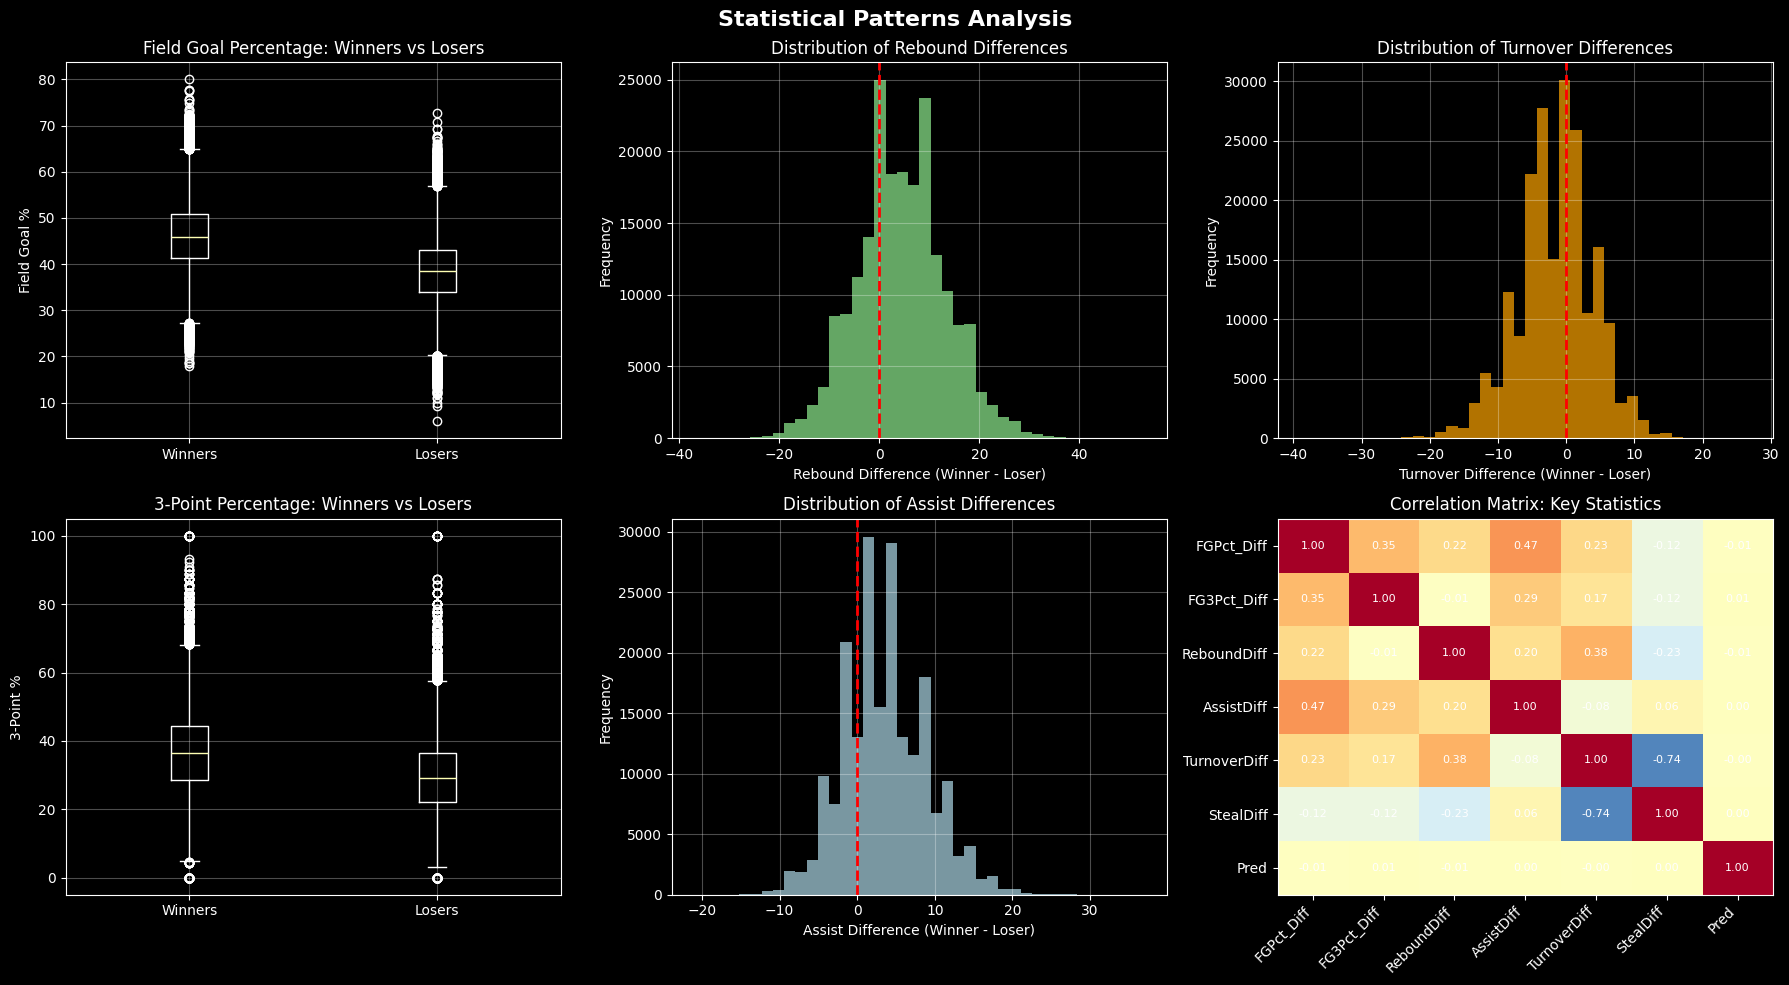

In [62]:
# Statistical patterns analysis
print("="*60)
print("STATISTICAL PATTERNS ANALYSIS")
print("="*60)

# Shooting efficiency analysis
print("🎯 SHOOTING EFFICIENCY:")
print(f"   Avg FG% (winners): {all_detailed_results['WFGPct'].mean()*100:.1f}%")
print(f"   Avg FG% (losers): {all_detailed_results['LFGPct'].mean()*100:.1f}%")
print(f"   Avg 3P% (winners): {all_detailed_results['WFG3Pct'].mean()*100:.1f}%")
print(f"   Avg 3P% (losers): {all_detailed_results['LFG3Pct'].mean()*100:.1f}%")
print(f"   Avg FT% (winners): {all_detailed_results['WFTPct'].mean()*100:.1f}%")
print(f"   Avg FT% (losers): {all_detailed_results['LFTPct'].mean()*100:.1f}%")

# Rebounding analysis
print(f"\n🏀 REBOUNDING:")
winner_rebounds = all_detailed_results['WOR'] + all_detailed_results['WDR']
loser_rebounds = all_detailed_results['LOR'] + all_detailed_results['LDR']
print(f"   Avg total rebounds (winners): {winner_rebounds.mean():.1f}")
print(f"   Avg total rebounds (losers): {loser_rebounds.mean():.1f}")
print(f"   Avg offensive rebounds (winners): {all_detailed_results['WOR'].mean():.1f}")
print(f"   Avg offensive rebounds (losers): {all_detailed_results['LOR'].mean():.1f}")

# Turnovers and steals
print(f"\n⚡ TURNOVERS AND STEALS:")
print(f"   Avg turnovers (winners): {all_detailed_results['WTO'].mean():.1f}")
print(f"   Avg turnovers (losers): {all_detailed_results['LTO'].mean():.1f}")
print(f"   Avg steals (winners): {all_detailed_results['WStl'].mean():.1f}")
print(f"   Avg steals (losers): {all_detailed_results['LStl'].mean():.1f}")

# Assists and teamwork
print(f"\n🤝 ASSISTS AND TEAMWORK:")
print(f"   Avg assists (winners): {all_detailed_results['WAst'].mean():.1f}")
print(f"   Avg assists (losers): {all_detailed_results['LAst'].mean():.1f}")

# Calculate correlations with winning
stats_for_correlation = all_detailed_results[['Pred', 'WFGPct', 'LFGPct', 'WFG3Pct', 'LFG3Pct', 
                                              'WFTPct', 'LFTPct', 'ReboundDiff', 'AssistDiff', 
                                              'TurnoverDiff', 'StealDiff', 'BlockDiff', 'FoulDiff']].copy()

# Calculate difference-based correlations (Winner - Loser)
stats_for_correlation['FGPct_Diff'] = stats_for_correlation['WFGPct'] - stats_for_correlation['LFGPct']
stats_for_correlation['FG3Pct_Diff'] = stats_for_correlation['WFG3Pct'] - stats_for_correlation['LFG3Pct']
stats_for_correlation['FTPct_Diff'] = stats_for_correlation['WFTPct'] - stats_for_correlation['LFTPct']

correlations = stats_for_correlation.corr()['Pred'].sort_values(ascending=False)

print(f"\n📊 CORRELATION WITH WINNING (top predictive stats):")
for stat, corr in correlations.items():
    if stat != 'Pred' and abs(corr) > 0.1:  # Only show meaningful correlations
        print(f"   {stat:15s}: {corr:6.3f}")

# Create statistical visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Statistical Patterns Analysis', fontsize=16, fontweight='bold')

# Shooting percentage comparison
fg_data = [all_detailed_results['WFGPct']*100, all_detailed_results['LFGPct']*100]
axes[0,0].boxplot(fg_data, labels=['Winners', 'Losers'])
axes[0,0].set_ylabel('Field Goal %')
axes[0,0].set_title('Field Goal Percentage: Winners vs Losers')
axes[0,0].grid(True, alpha=0.3)

# Rebound difference distribution
axes[0,1].hist(all_detailed_results['ReboundDiff'], bins=40, alpha=0.7, color='lightgreen')
axes[0,1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0,1].set_xlabel('Rebound Difference (Winner - Loser)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Distribution of Rebound Differences')
axes[0,1].grid(True, alpha=0.3)

# Turnover difference
axes[0,2].hist(all_detailed_results['TurnoverDiff'], bins=40, alpha=0.7, color='orange')
axes[0,2].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0,2].set_xlabel('Turnover Difference (Winner - Loser)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].set_title('Distribution of Turnover Differences')
axes[0,2].grid(True, alpha=0.3)

# 3-point shooting comparison
fg3_data = [all_detailed_results['WFG3Pct']*100, all_detailed_results['LFG3Pct']*100]
axes[1,0].boxplot(fg3_data, labels=['Winners', 'Losers'])
axes[1,0].set_ylabel('3-Point %')
axes[1,0].set_title('3-Point Percentage: Winners vs Losers')
axes[1,0].grid(True, alpha=0.3)

# Assist difference
axes[1,1].hist(all_detailed_results['AssistDiff'], bins=40, alpha=0.7, color='lightblue')
axes[1,1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1,1].set_xlabel('Assist Difference (Winner - Loser)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Assist Differences')
axes[1,1].grid(True, alpha=0.3)

# Correlation heatmap (subset)
important_stats = ['FGPct_Diff', 'FG3Pct_Diff', 'ReboundDiff', 'AssistDiff', 'TurnoverDiff', 'StealDiff']
corr_subset = stats_for_correlation[important_stats + ['Pred']].corr()

im = axes[1,2].imshow(corr_subset.values, cmap='RdYlBu_r', aspect='auto', vmin=-1, vmax=1)
axes[1,2].set_xticks(range(len(corr_subset.columns)))
axes[1,2].set_yticks(range(len(corr_subset.columns)))
axes[1,2].set_xticklabels(corr_subset.columns, rotation=45, ha='right')
axes[1,2].set_yticklabels(corr_subset.columns)
axes[1,2].set_title('Correlation Matrix: Key Statistics')

# Add correlation values as text
for i in range(len(corr_subset.columns)):
    for j in range(len(corr_subset.columns)):
        axes[1,2].text(j, i, f'{corr_subset.iloc[i, j]:.2f}', 
                      ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()


## Feature Engineering


Now we have to begin setting up the data for the model. We will group the detailed results by the IDTeams and then aggregate the data. We will also create a sample submission dataframe that will be used to store the predictions for the sample submission, this will be populated with the predictions from the model later on.

In [63]:
c_score_col = ['NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl',
 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl',
 'LBlk', 'LPF']
c_score_agg = ['sum', 'mean', 'median', 'max', 'min', 'std', 'skew', 'nunique']
gb = all_detailed_results.groupby(by=['IDTeams']).agg({k: c_score_agg for k in c_score_col}).reset_index()
gb.columns = [''.join(c) + '_c_score' for c in gb.columns]

sub['WLoc'] = 3
sub['Season'] = sub['ID'].map(lambda x: x.split('_')[0])
sub['Season'] = sub['ID'].map(lambda x: x.split('_')[0])
sub['Season'] = sub['Season'].astype(int)
sub['Team1'] = sub['ID'].map(lambda x: x.split('_')[1])
sub['Team2'] = sub['ID'].map(lambda x: x.split('_')[2])
sub['IDTeams'] = sub.apply(lambda r: '_'.join(map(str, [r['Team1'], r['Team2']])), axis=1)
sub['IDTeam1'] = sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
sub['IDTeam2'] = sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)
sub['Team1Seed'] = sub['IDTeam1'].map(seeds).fillna(0)
sub['Team2Seed'] = sub['IDTeam2'].map(seeds).fillna(0)
sub['SeedDiff'] = sub['Team1Seed'] - sub['Team2Seed'] 
sub = sub.fillna(-1)

games = pd.merge(all_detailed_results, gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')
sub = pd.merge(sub, gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')

col = [c for c in games.columns if c not in ['ID', 'DayNum', 'ST', 'Team1', 'Team2', 'IDTeams', 'IDTeam1', 'IDTeam2', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'NumOT', 'Pred', 'ScoreDiff', 'ScoreDiffNorm', 'WLoc'] + c_score_col]

## Model Training

Now we can begin training the model. We will use a simple XGBoost model to predict the outcome of the game. We will also use a simple imputer to fill in the missing values and a standard scaler to scale the data.

In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import brier_score_loss, log_loss

imputer = SimpleImputer(strategy='mean')  
scaler = StandardScaler()

X = games[col].fillna(-1)
missing_cols = set(col) - set(sub.columns)
for c in missing_cols:
    sub[c] = 0

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

# Fixed: Use XGBClassifier for probability prediction
model = xgb.XGBClassifier(
    n_estimators=3000,         # Reduced from 5000 for faster training
    learning_rate=0.05,        # Learning rate for gradient boosting
    max_depth=6,               # Control model complexity
    min_child_weight=3,        # Helps prevent overfitting
    subsample=0.8,             # Use 80% of data for each tree
    colsample_bytree=0.8,      # Use 80% of features for each tree
    objective='binary:logistic', # Proper binary classification objective
    random_state=42,
    n_jobs=-1,                 # Use all CPU cores
    eval_metric='logloss'      # Use log loss for evaluation
)

# Implement time-aware cross-validation
def time_aware_cv(model, X, y, seasons, n_splits=5):
    """
    Perform time-aware cross-validation where we train on earlier seasons
    and validate on later seasons to prevent data leakage.
    """
    unique_seasons = sorted(seasons.unique())
    cv_scores = []
    
    # Calculate split points for time-based CV
    season_splits = []
    split_size = len(unique_seasons) // (n_splits + 1)
    
    for i in range(n_splits):
        train_end_idx = split_size * (i + 2)  # End of training seasons
        val_start_idx = train_end_idx
        val_end_idx = min(train_end_idx + split_size, len(unique_seasons))
        
        if val_end_idx > len(unique_seasons):
            break
            
        train_seasons = unique_seasons[:train_end_idx]
        val_seasons = unique_seasons[val_start_idx:val_end_idx]
        
        season_splits.append((train_seasons, val_seasons))
    
    print(f"Time-aware CV with {len(season_splits)} splits:")
    
    for i, (train_seasons, val_seasons) in enumerate(season_splits):
        # Create train/val masks
        train_mask = seasons.isin(train_seasons)
        val_mask = seasons.isin(val_seasons)
        
        if train_mask.sum() == 0 or val_mask.sum() == 0:
            continue
            
        X_train_fold, X_val_fold = X[train_mask], X[val_mask]
        y_train_fold, y_val_fold = y[train_mask], y[val_mask]
        
        # Fit model on training fold
        model.fit(X_train_fold, y_train_fold)
        
        # Predict on validation fold
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        y_pred_proba = np.clip(y_pred_proba, 0.001, 0.999)
        
        # Calculate metrics
        brier = brier_score_loss(y_val_fold, y_pred_proba)
        logloss = log_loss(y_val_fold, y_pred_proba)
        
        cv_scores.append(brier)
        
        print(f"  Fold {i+1}: Train seasons {train_seasons[0]}-{train_seasons[-1]} | "
              f"Val seasons {val_seasons[0]}-{val_seasons[-1]} | "
              f"Brier: {brier:.4f} | LogLoss: {logloss:.4f}")
    
    return cv_scores

# Perform time-aware cross-validation
print("\nPerforming time-aware cross-validation...")
cv_brier_scores = time_aware_cv(model, X_scaled, games['Pred'], games['Season'])

print(f"\nTime-aware CV Results:")
print(f"Mean Brier Score: {np.mean(cv_brier_scores):.4f} ± {np.std(cv_brier_scores):.4f}")

# Train the final model on all data
print("\nTraining final model on all data...")
model.fit(X_scaled, games['Pred'])

# Get predictions with proper probability output
pred_proba = model.predict_proba(X_scaled)[:, 1]  # Get probability of class 1
pred_proba = np.clip(pred_proba, 0.001, 0.999)

print(f'\nFinal Model Performance on Training Data:')
print(f'Log Loss: {log_loss(games["Pred"], pred_proba):.4f}')
print(f'Mean Absolute Error: {mean_absolute_error(games["Pred"], pred_proba):.4f}')
print(f'Brier Score: {brier_score_loss(games["Pred"], pred_proba):.4f}')



Performing time-aware cross-validation...
Time-aware CV with 5 splits:
  Fold 1: Train seasons 2003-2008 | Val seasons 2009-2011 | Brier: 0.2346 | LogLoss: 0.6801
  Fold 2: Train seasons 2003-2011 | Val seasons 2012-2014 | Brier: 0.2210 | LogLoss: 0.6335
  Fold 3: Train seasons 2003-2014 | Val seasons 2015-2017 | Brier: 0.2105 | LogLoss: 0.6018
  Fold 4: Train seasons 2003-2017 | Val seasons 2018-2020 | Brier: 0.2178 | LogLoss: 0.6185
  Fold 5: Train seasons 2003-2020 | Val seasons 2021-2023 | Brier: 0.2074 | LogLoss: 0.5928

Time-aware CV Results:
Mean Brier Score: 0.2182 ± 0.0095

Training final model on all data...

Final Model Performance on Training Data:
Log Loss: 0.3667
Mean Absolute Error: 0.2839
Brier Score: 0.1095


In [20]:
# Fill in missing values for submission data
sub_X = sub[col].fillna(-1)

print("Shape of sub_X:", sub_X.shape)
print("Creating imputed data...")

# Transform using fitted imputer and scaler
sub_X_imputed = imputer.transform(sub_X)
print("Scaling data...")
sub_X_scaled = scaler.transform(sub_X_imputed)

print("Making predictions...")
# Use predict_proba for proper probability output with XGBClassifier
predictions = model.predict_proba(sub_X_scaled)[:, 1]  # Get probability of class 1
predictions = np.clip(predictions, 0.001, 0.999)
print("Prediction shape:", predictions.shape)

# Assign to dataframe
sub['Pred'] = predictions
print("Saving to CSV...")
sub[['ID', 'Pred']].to_csv('submission.csv', index=False)
print("Done!")

Shape of sub_X: (507108, 234)
Creating imputed data...
Scaling data...
Making predictions...
Prediction shape: (507108,)
Saving to CSV...
Done!
